# Investigation

This will be my attempt at creating something similar to the original notebook.
A few things to think about:

- After doing the initial recreation, let's look at the Kaggle tutorials and add in other data points
  - Close - n datapoints? So we're not just using the very latest close price
  - High/Low/Open - see if these are useful
  - Tick volume - see if this is useful
- As well as looking at root mean squared error, lets look at statistics
  - When model predict a move of more than 1, 2, 3 ATR in next 10, 15 candles, how often does this actually happen?
    - When it's correct, how often is there a move in the opposite direction first that was not seen by model
  - When it predicts a positive or negative move, how often is it actually correct?
    - Look at this over different candle counts. ie. Candle 1, 10, 15
- Rather than predict the price, try predict the change?
  - The price may hit values never encountered in training which may make it harder to predict

Hopefully, we will find models that are better than the original but there's not going to be a model we can use for native price forcasting. But perhaps we can use it to inform other prediction algorithms. ie. If we have an algorithm that identifies support and resistance areas, and the model is good a predicting the direction of the movement then it can be used to inform on where to place a trade even if it can't predict the price.

### Note

In this repo I am using a custom module `malfoy.metatrader` that I built on top of the `MetaTrader5` package. This interfaces directly with MetaTrader to pull up-to-date data. I hope to eventually make this open-source but for now it's a private module. I have also saved the data used in `./data/new` so it can be reused.

In [94]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib widget

In [95]:
# Functions

def CreateScaler(data: pd.Series) -> MinMaxScaler:
  data = np.array(data).reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data)

  return scaler

def GetScaledData(data: pd.Series, scaler: MinMaxScaler) -> pd.Series:
  data = np.array(data).reshape(-1, 1)
  return scaler.transform(data)

def GetTimeStepDataFrame(data: pd.DataFrame, timeSteps: int, trainingColumns: list, predictionColumn: str) -> pd.DataFrame:
  
  timeStepData = pd.DataFrame(index=data.index)

  for column in trainingColumns:
    for i in range(1, timeSteps + 1):
      newColName = "{0}_{1}".format(column, i)
      timeStepData[newColName] = data[column].shift(i)

  timeStepData[predictionColumn] = data[predictionColumn]
  
  timeStepData = timeStepData.dropna()

  return timeStepData

def GetTimeStepDict(data: pd.DataFrame, timeSteps: int, trainingColumns: list) -> dict:
  
  timeStepData = {}

  for column in trainingColumns:
    for i in range(1, timeSteps + 1):
      newColName = "{0}_{1}".format(column, i)
      timeStepData[newColName] = data[column].iloc[timeSteps - i]

  return timeStepData

## Variables

These core variables are used throughout the scripts. The instrument and granularity variables can be used to change the target of predictions. These correspond to the data found in `./data/new/`

*Prediction Variables*:
- instrument - the instrument being predicted
- granularity - the timeframe being predicted on (One minute, one hour, one day, etc)
- lookbackTimeSteps - the number of previous time steps to use in making the prediction for the current candle
- predictionColumn - the column from the dataframe we are trying to predict

In [96]:
# Set script variables
seedValue = 72
trainingSizePercent = 0.7
inputDataFolder = "./input/new"

# Change these for prediction changes
instrument = "BTCUSD"
granularity = "D1"
lookbackTimeSteps = 15
predictionColumn = "midCloseDelta"

In [97]:
# Import data

rawDataFilePath = "{0}/{1}_{2}.csv".format(inputDataFolder, instrument, granularity)
rawData = pd.read_csv(rawDataFilePath)

rawData

,Unnamed: 0,instrument,granularity,time,stringTime,volume,bidOpen,bidHigh,bidLow,bidClose,midOpen,midHigh,midLow,midClose,askOpen,askHigh,askLow,askClose
0,0,BTCUSD,D1,2013-11-15,2013-11-15T00:00:00,1,433.00,458.0,413.00,434.00,433.00,458.0,413.00,434.00,433.00,458.0,413.00,434.00
1,1,BTCUSD,D1,2013-11-16,2013-11-16T00:00:00,1,434.00,477.0,428.00,462.00,434.00,477.0,428.00,462.00,434.00,477.0,428.00,462.00
2,2,BTCUSD,D1,2013-11-17,2013-11-17T00:00:00,1,462.00,537.0,457.00,528.00,462.00,537.0,457.00,528.00,462.00,537.0,457.00,528.00
3,3,BTCUSD,D1,2013-11-18,2013-11-18T00:00:00,1,528.00,788.0,522.00,785.00,528.00,788.0,522.00,785.00,528.00,788.0,522.00,785.00
4,4,BTCUSD,D1,2013-11-19,2013-11-19T00:00:00,1,785.00,901.0,502.00,645.00,785.00,901.0,502.00,645.00,785.00,901.0,502.00,645.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,2732,BTCUSD,D1,2022-04-16,2022-04-16T00:00:00,196699,40399.00,40692.5,39997.09,40315.48,40399.00,40692.5,39997.09,40315.48,40399.00,40692.5,39997.09,40315.48
2733,2733,BTCUSD,D1,2022-04-17,2022-04-17T00:00:00,233558,40281.43,40694.5,39819.11,40266.50,40281.43,40694.5,39819.11,40266.50,40281.43,40694.5,39819.11,40266.50
2734,2734,BTCUSD,D1,2022-04-18,2022-04-18T00:00:00,258386,40260.50,41090.0,38518.81,40655.50,40260.50,41090.0,38518.81,40655.50,40260.50,41090.0,38518.81,40655.50
2735,2735,BTCUSD,D1,2022-04-19,2022-04-19T00:00:00,259843,40669.50,41751.0,40566.50,41277.00,40669.50,41751.0,40566.50,41277.00,40669.50,41751.0,40566.50,41277.00


In [98]:
# Pre-process data

ppData = rawData.copy()

# New columns
ppData["askCloseDelta"] = ppData["askClose"] - ppData["askClose"].shift(1)
ppData["midCloseDelta"] = ppData["midClose"] - ppData["midClose"].shift(1)
ppData["bidCloseDelta"] = ppData["bidClose"] - ppData["bidClose"].shift(1)

# Split data in to test and train
trainingEntryCount = math.floor(len(ppData) * trainingSizePercent)
trainingData = ppData.iloc[0:trainingEntryCount, :]
testData = ppData.iloc[trainingEntryCount:len(ppData), :]

# Scale required columns
scaledColumns = ["bidOpen", "bidHigh", "bidLow", "midOpen", "midHigh", "midLow", "askOpen", "askHigh", "askLow", "volume", "bidClose", "midClose", "askClose", "midCloseDelta"]

scalerDict = {}

for column in scaledColumns:
  scalerDict[column] = CreateScaler(trainingData[column])
  
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
  testData[column] = GetScaledData(testData[column], scalerDict[column])

# Add previous time steps as data available for making prediction
trainingColumns = ["midClose", "midCloseDelta"]

trainingTimeStepData = GetTimeStepDataFrame(trainingData, timeSteps=lookbackTimeSteps, trainingColumns=trainingColumns, predictionColumn=predictionColumn)
X_trainingData = trainingTimeStepData.drop(columns=predictionColumn)
Y_trainingData = trainingTimeStepData[predictionColumn]

testTimeStepData = GetTimeStepDataFrame(testData, timeSteps=lookbackTimeSteps, trainingColumns=trainingColumns, predictionColumn=predictionColumn)
X_testData = testTimeStepData.drop(columns=predictionColumn)
Y_testData = testTimeStepData[predictionColumn]

print("X_trainingData shape:", X_trainingData.shape)
print("Y_trainingData shape:", Y_trainingData.shape)
print("X_testData shape:", X_testData.shape)
print("Y_testData shape:", Y_testData.shape)

X_trainingData.to_csv("./train.csv")
trainingData.to_csv("./train_raw.csv")
X_testData.to_csv("./test.csv")
testData.to_csv("./test_raw.csv")

C:\Users\sambe\AppData\Local\Temp\ipykernel_14820\1779396000.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_14820\1779396000.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData[column] = GetScaledData(testData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_14820\1779396000.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

X_trainingData shape: (1899, 30)
Y_trainingData shape: (1899,)
X_testData shape: (807, 30)
Y_testData shape: (807,)


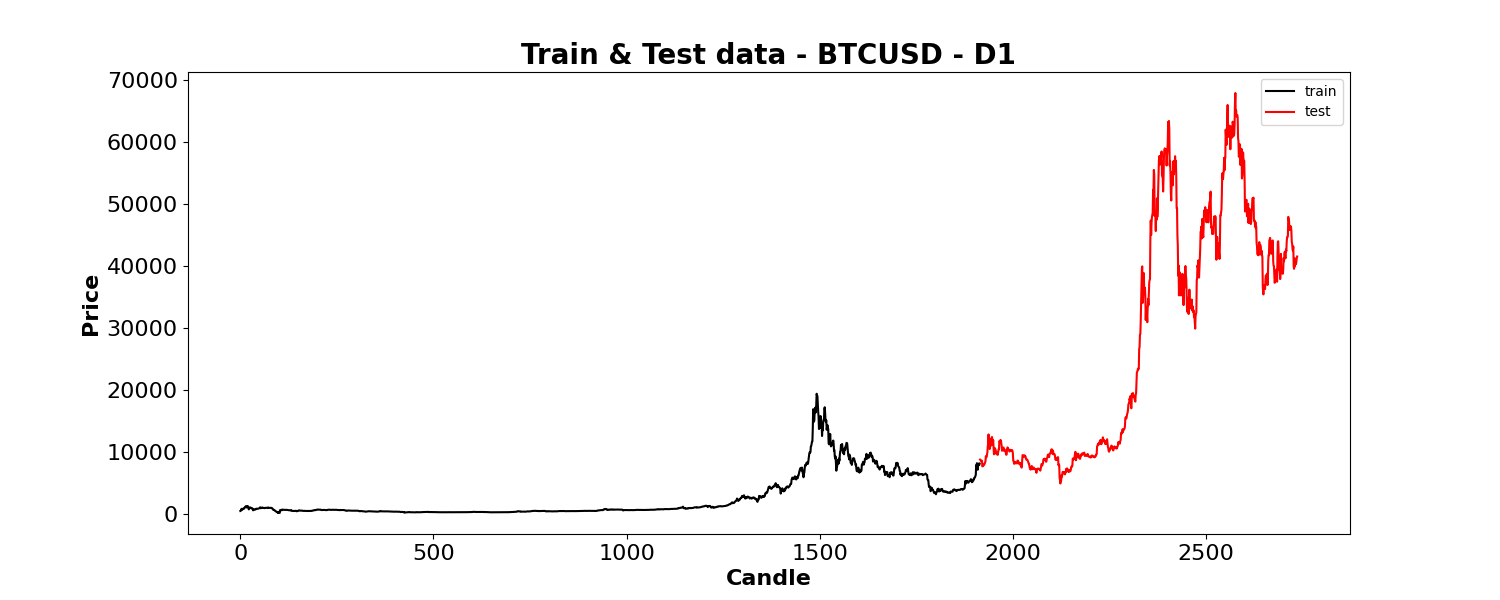

In [99]:
# Plot test and train data

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')

# Formatting
ax.set_title('Train & Test data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [100]:
# Train model

model = XGBRegressor(n_estimators=10000, seed=seedValue)
model.fit(X_trainingData, Y_trainingData, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=72,
             reg_alpha=0, reg_lambda=1, ...)

In [101]:
# Model testing and evaluation

predictions = model.predict(X_testData)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_testData, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(Y_testData, predictions))))

Mean Absolute Error - MAE : 0.162692317435341
Root Mean squared Error - RMSE : 0.25785203994006933


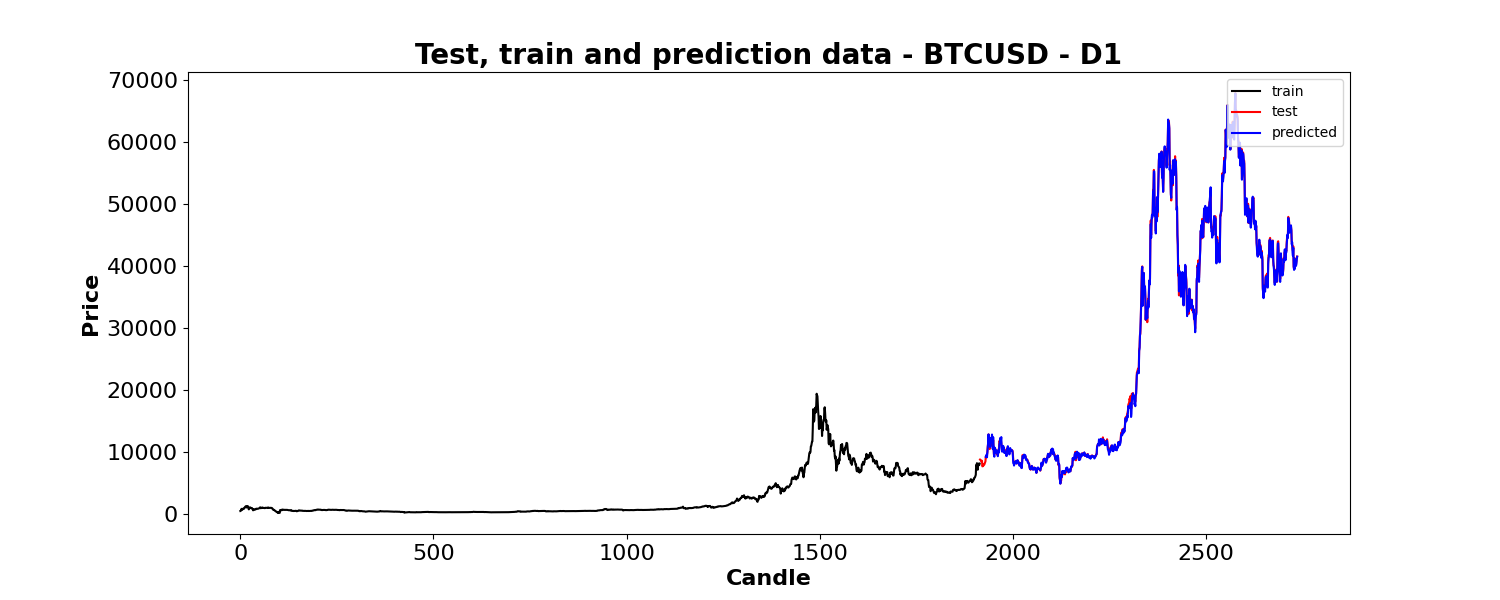

In [102]:
# Plot the predicted vs actual
plotTestData = X_testData.copy()

plotTestData["midClose"] = testData["midClose"]
plotTestData["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotTestData["midClose"]).reshape(-1, 1))
plotTestData["PredictedValue"] = scalerDict[predictionColumn].inverse_transform(np.array(predictions).reshape(-1, 1))
plotTestData["PredictedValue"] = plotTestData["PredictedValue"] + plotTestData["midClose"]

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')
sns.lineplot(x = plotTestData.index, y = plotTestData['PredictedValue'], color = 'blue')

# Formatting
ax.set_title('Test, train and prediction data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test', "predicted"))


## Future prediction

This next part is an attempt to use previous predictions to then predict the next step. This will obviously not be as accurate as predicting one step ahead for two reasons:
- The further in the future you are trying to predict, the higher the uncertainty.
- We will be using previous predictions as inputs to the next prediction. This will add error and more uncertainty.]

## Findings

Using this current method for future trends seems highly error-prone. Assuming there is nothing wrong in the code below (I've double checked but there still could be), creating predictions of the previous predictions just introduces too much error. One time step seems to be within a reasonable error range but after that it declines rapidly.

I'm going to create another notebook that predicts the xth step in the future. ie. instead of predicting the next candle close, predict the 5th candle close. It will be interesting to see the accuracy of this.

In [103]:
futureTestData = testData.copy().head(200)

stepsToPredict = 200

# Sets the index value for the next dataframe entry
nextIndexValue = futureTestData.index.values[-1] + 1

for i in range(stepsToPredict):
  previousClose = scalerDict["midClose"].inverse_transform(np.array(futureTestData["midClose"].values[-1]).reshape(-1, 1))[0][0]

  # Get values needed to predict next step
  nextTimeStep = GetTimeStepDict(futureTestData.tail(lookbackTimeSteps), timeSteps=lookbackTimeSteps, trainingColumns=trainingColumns)
  
  # Predict next step
  prediction = model.predict(pd.DataFrame(nextTimeStep, index=[nextIndexValue]))[0]
  
  # Store predictions in dataframe
  nextTimeStep[predictionColumn] = prediction
  predictionUnscaled = scalerDict[predictionColumn].inverse_transform(np.array(prediction).reshape(-1, 1))
  
  predictedClose = previousClose + predictionUnscaled
  nextTimeStep["midClose"] = scalerDict["midClose"].transform(predictedClose)[0][0]
  futureTestData = pd.concat([futureTestData, pd.DataFrame(nextTimeStep, index=[nextIndexValue])])

  print("Previous close:", previousClose)
  print("Predicted move:", predictionUnscaled[0][0])
  print("Predicted close:", predictedClose[0][0])

  nextIndexValue = nextIndexValue + 1

Previous close: 8720.0
Predicted move: 75.28436
Predicted close: 8795.284
Previous close: 8795.28448432684
Predicted move: 286.14432
Predicted close: 9081.429
Previous close: 9081.42913812399
Predicted move: 46.882385
Predicted close: 9128.312
Previous close: 9128.311909645796
Predicted move: 110.6866
Predicted close: 9238.998
Previous close: 9238.997964411974
Predicted move: 131.29385
Predicted close: 9370.292
Previous close: 9370.292422920465
Predicted move: 43.385498
Predicted close: 9413.678
Previous close: 9413.678174048662
Predicted move: 7.740091
Predicted close: 9421.418
Previous close: 9421.417932510376
Predicted move: -403.5264
Predicted close: 9017.892
Previous close: 9017.891814142466
Predicted move: -27.419298
Predicted close: 8990.473
Previous close: 8990.472789794207
Predicted move: -136.34802
Predicted close: 8854.125
Previous close: 8854.125105291605
Predicted move: -92.86609
Predicted close: 8761.259
Previous close: 8761.258894324303
Predicted move: -5.97059
Predicted

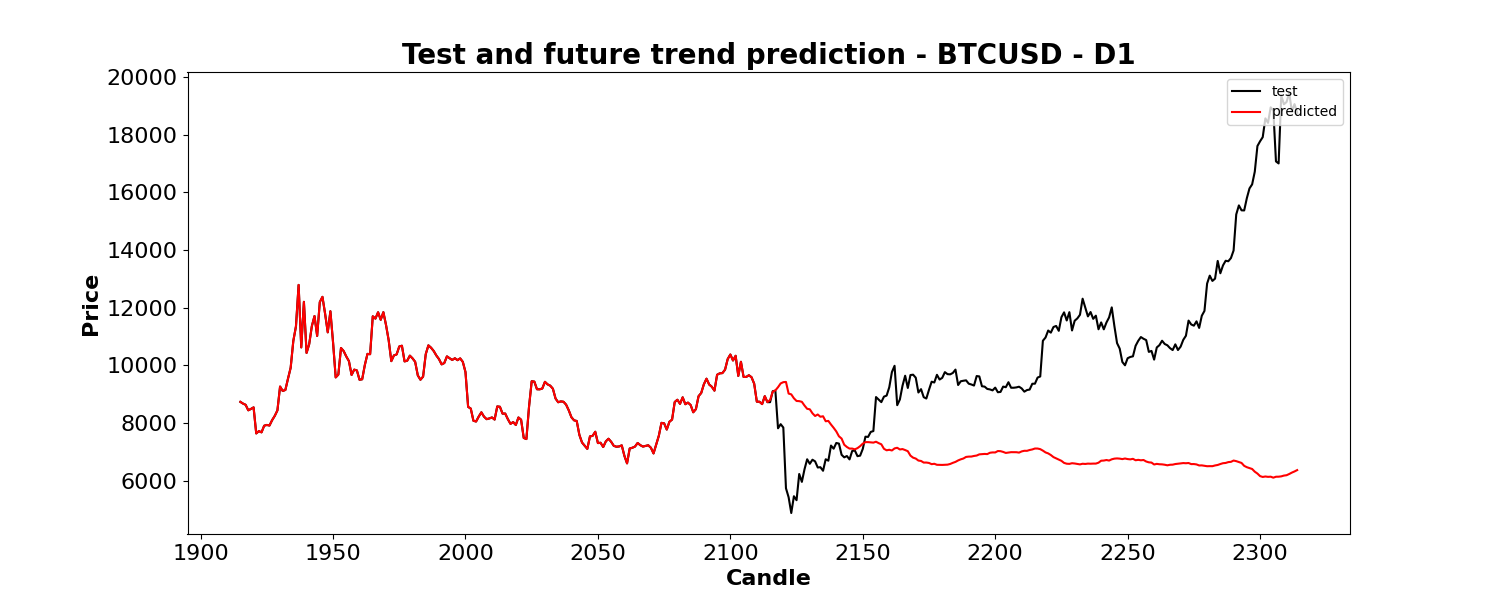

In [104]:
# Plot predicted steps
plotFutureData = futureTestData.copy()

plotTestSubset = testData.loc[plotFutureData.index.values]

plotFutureData["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotFutureData["midClose"]).reshape(-1, 1))
plotTestSubset["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotTestSubset["midClose"]).reshape(-1, 1))

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = plotTestSubset.index.values, y = plotTestSubset['midClose'], color = 'black')
sns.lineplot(x = plotFutureData.index.values, y = plotFutureData['midClose'], color = 'red')

# Formatting
ax.set_title('Test and future trend prediction - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('test', "predicted"))